<center>
    <img src="./images/mlfasp.png">
</center>

#### Prof. Dr. -Ing. Gerald Schuller <br> Jupyter Notebook: Renato Profeta

[Applied Media Systems Group](https://www.tu-ilmenau.de/en/applied-media-systems-group/) <br>
[Technische Universität Ilmenau](https://www.tu-ilmenau.de/)

# Convolutional Neural Networks

In [24]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/r3KF3-H61QQ?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

So far we used fully connected layers, where the input is fully connected to each node in the following layer. Convolutional neural networks use a "filter kernel" instead, where each node is conduction a convolution like a filter.

The filter kernel is also described as a "receptive field" of a certain size. At each position of this receptive field, an output is produced. Then it is shifted by a distance called "stride", and a new output is produced, and so on.

This has the advantage, that the network is less dependent on the precise location of a signal to detect or recognize.

There are convolutional layer for 1 to 3 dimensions:

```python
torch.nn.Conv1d
torch.nn.Conv2d
torch.nn.Conv3d
```

For the case of the MNIST digit recognition we need 2d convolution, defined as:

```python
torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
                stride=1, padding=0, dilation=1, groups=1, 
                bias=True, padding_mode='zeros')
```

In [28]:
%%html
<iframe src="https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d" width="900" height="600"></iframe>

"padding" here means a zero padding at the ends of the signals, for instance the boundary of our images. For padding=0, only valid points are computed, which means the kernel does not reach over the boundaries. For instance if the kernel has a size of 3, we need "padding=1" to obtain the same output size as the input.

This is the Pytorch convolutional neural network class for the MNIST digit recognition task,

```python
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(20, 10)
        
    def forward(self, x):
        #print("x_input.shape=", x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 4))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        #print("x.shape=", x.shape)
        x = x.view(-1, 20) 
        #80 for pool: 2,4; ((((28-(5-1))/2-(5-1))/4)**2)*20
        #20 for pool: 4,2: ((((28-(5-1))/4-(5-1))/2)**2)*20
        x = F.relu(self.fc1(x)) #10 outputs, 1 for each class.
        return x #F.log_softmax(x)
```

For the loss function we take again the CrossEntroyLoss, and for the optimizer "adam",

```python
torch.save({'model_state_dict':model.state_dict(),'optimizer_state_dict':optimizer.state_dict()},
           "mnistexample_pytorch_convnet2_weights.torch")
```

We can compare this with the case of our fully connected network, and will see that indeed we only have a fraction of the weights in our convolutional network compared with the fully connected network. This is an advantage for an implementation on smaller hardware.

We can then train the convolutional network as before. Here we see a disadvantage: it takes much longer to train, we need 1000 iterations or more to obtain a good solution, as compared to only 10 iterations for the fully connected network!


In [1]:
#from: https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/
#https://pytorch.org/docs/stable/torchvision/datasets.html#mnist
#Translated to PyTorch, and using a convulutional neural network instead, 
#2: with more conv layers
#by Gerald Schuller, October 2019

# Ported to Jupyter Notebook by Renato Profeta, October 2020

In [2]:
import numpy
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import time

device='cpu'
#device='cuda'

In [3]:
# define baseline model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(20, 10)

    def forward(self, x):
        #print("x_input.shape=", x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 4))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        #print("x.shape=", x.shape)
        x = x.view(-1, 20) #80 for pool: 2,4; ((((28-(5-1))/2-(5-1))/4)**2)*20
        #20 for pool: 4,2: ((((28-(5-1))/4-(5-1))/2)**2)*20
        x = F.relu(self.fc1(x)) #10 outputs, 1 for each class.
        return x #F.log_softmax(x)

In [4]:
batch_size_train = 100
batch_size_test = 10
num_classes = 10

In [5]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/Downloads/MNISTfiles/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=False)

#the Normalize numbers are mean and standard deviation.
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/Downloads/MNISTfiles/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [6]:
examples = enumerate(train_loader)
# Plot ad hoc mnist instances

# load (downloaded if needed) the MNIST dataset
#(X_train, y_train), (X_test, y_test) = mnist.load_data()
#one batch of 100 images:
batch_idx, (X_train, y_train) = next(examples)
print("batch_idx=", batch_idx, "X_train.shape=", X_train.shape, "y_train.shape=", y_train.shape, "y_train=", y_train)
examples = enumerate(test_loader)
#one batch of 100 images:
batch_idx, (X_test, y_test) = next(examples)

batch_idx= 0 X_train.shape= torch.Size([100, 1, 28, 28]) y_train.shape= torch.Size([100]) y_train= tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7,
        1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0,
        7, 8, 3, 1])


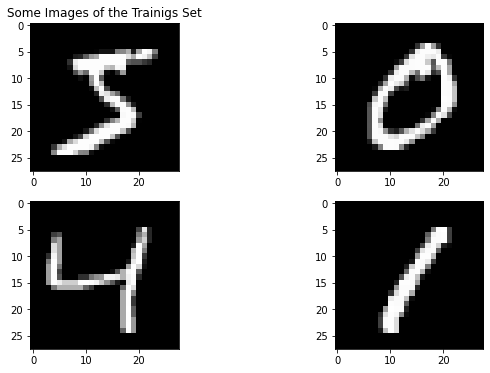

In [7]:
# plot 4 images as gray scale
plt.figure(figsize=(10,6))
plt.subplot(221)
plt.title("Some Images of the Trainigs Set")
plt.imshow(X_train[0,0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1,0], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2,0], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3,0], cmap=plt.get_cmap('gray'))
# show the plot


X_testunflat=X_test.clone() #keep original for imshow later
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[2] * X_train.shape[3]


In [8]:
# build the model
print("Generate Model:")
model = ConvNet()#.to('cpu')
    
loss_fn = nn.CrossEntropyLoss()
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)

try:
    checkpoint = torch.load("mnistexample_pytorch_convnet2_weights.torch",map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Read weights from mnistexample_pytorch_convnet2_weights.torch")
except IOError:
    print("fresh start")

Generate Model:
Read weights from mnistexample_pytorch_convnet2_weights.torch


In [9]:
# Fit the model
X_train=X_train.to(device)
y_train=y_train.to(device)
starttime=time.time()
for epoch in range(1000):
    Ypred=model(X_train)
    loss=loss_fn(Ypred, y_train)
    if epoch%2==0:
        print(epoch, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
endtime=time.time()
print("Duration of optimization:", endtime-starttime)

#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=200, verbose=2)
# Final evaluation of the model
Ypred=model(X_test)
loss=loss_fn(Ypred, y_test)
#scores = model.forward(X_test, y_test, verbose=0)
print("Loss on the test set:", loss)

0 1.10525643825531
2 1.1052542924880981
4 1.1052520275115967
6 1.1052504777908325
8 1.1052489280700684
10 1.1052478551864624
12 1.1052470207214355
14 1.1052460670471191
16 1.105245590209961
18 1.1052452325820923
20 1.1052448749542236
22 1.105244517326355
24 1.1052443981170654
26 1.1052441596984863
28 1.1052441596984863
30 1.1052440404891968
32 1.1052438020706177
34 1.1052436828613281
36 1.1052435636520386
38 1.1052433252334595
40 1.1052433252334595
42 1.10524320602417
44 1.10524320602417
46 1.10524320602417
48 1.1052429676055908
50 1.1052429676055908
52 1.1052429676055908
54 1.1052428483963013
56 1.1052427291870117
58 1.1052427291870117
60 1.1052427291870117
62 1.1052427291870117
64 1.1052426099777222
66 1.1052426099777222
68 1.1052424907684326
70 1.1052424907684326
72 1.105242371559143
74 1.105242371559143
76 1.105242371559143
78 1.105242371559143
80 1.1052422523498535
82 1.1052422523498535
84 1.1052422523498535
86 1.1052422523498535
88 1.105242133140564
90 1.105242133140564
92 1.1052

734 1.1052416563034058
736 1.1052416563034058
738 1.1052416563034058
740 1.1052416563034058
742 1.1052415370941162
744 1.1052414178848267
746 1.1052414178848267
748 1.1052414178848267
750 1.1052414178848267
752 1.1052414178848267
754 1.1052414178848267
756 1.1052414178848267
758 1.1052414178848267
760 1.1052414178848267
762 1.1052414178848267
764 1.1052414178848267
766 1.1052414178848267
768 1.1052414178848267
770 1.1052414178848267
772 1.1052414178848267
774 1.105241298675537
776 1.105241298675537
778 1.105241298675537
780 1.105241298675537
782 1.105241298675537
784 1.105241298675537
786 1.105241298675537
788 1.105241298675537
790 1.105241298675537
792 1.105241298675537
794 1.105241298675537
796 1.105241298675537
798 1.105241298675537
800 1.105241298675537
802 1.105241298675537
804 1.105241298675537
806 1.105241298675537
808 1.105241298675537
810 1.105241298675537
812 1.105241298675537
814 1.105241298675537
816 1.1052411794662476
818 1.1052411794662476
820 1.1052411794662476
822 1.105

Wrote to mnistexample_pytorch_convnet2_weights.torch
sample.shape= torch.Size([1, 1, 28, 28])
prediction= tensor(2)


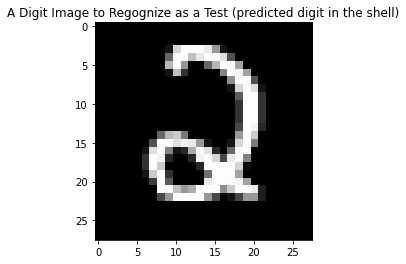

In [15]:
torch.save({
       'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict()}, "mnistexample_pytorch_convnet2_weights.torch")
print("Wrote to mnistexample_pytorch_convnet2_weights.torch")

plt.figure()
plt.imshow(X_testunflat[3,0], cmap=plt.get_cmap('gray'))
plt.title("A Digit Image to Regognize as a Test (predicted digit in the shell)")

sample=X_test[3,:]
sample=sample[None,:,:,:] #add the batch dimension for conv2d input.
print("sample.shape=", sample.shape)
prediction=torch.argmax(model(sample))
print("prediction=", prediction)

## 1-D Convolutional Networks for Audio Processing

### A 1-D Signal Detector

In [25]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/bIIXxoeyqTI?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

We can use 1-dimensional convolutional networks for audio processing. Examples are matched filters and predictors, as shown in letcure 13 and 14 of Advanced Signal Processing.

Construct a signal "sig" (length 11):

In [23]:
%%html
<a href="https://github.com/GuitarsAI/ADSP_Tutorials">https://github.com/GuitarsAI/ADSP_Tutorials</a><br>
<iframe width="560" height="315" src="https://www.youtube.com/embed/1tuLWEzDe3o?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
<iframe width="560" height="315" src="https://www.youtube.com/embed/fKrlRUFPrDg?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [39]:
import numpy as np,
sig = np.arange(0, 1.1, 0.1)
sig

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

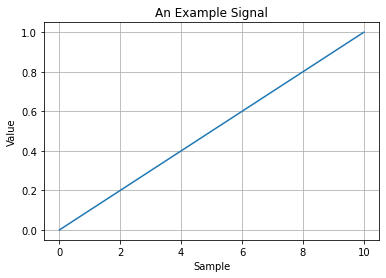

In [40]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(sig)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('An Example Signal')
plt.grid()

Now we add noise and extend the length of our signal:

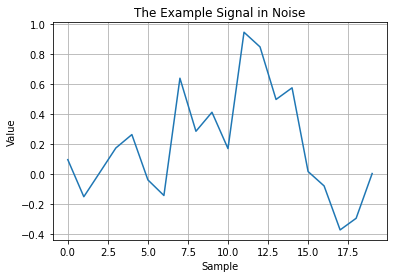

In [41]:
signoise = np.random.rand(20)-0.5+np.hstack([np.zeros(4),sig,np.zeros(5)])
plt.figure()
plt.plot(signoise)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('The Example Signal in Noise')
plt.grid()

We need to convert this signal to a pytorch type, and write a function "signal2pytorch(x)" for it.

We can implement a filter similar to a matched filter using a 1-dimensional "convolutional layer", conv1d, without "bias" and without a non-linear "activation function".

For it we need to specify a "training" signal, here our signal to detect (the "ramp" function) x, and the "target" signal y, which is the desired output of the convolutional layer which the optimization should reach as closely as possible during the optimization or "training",

```python
x= np.hstack((np.zeros(4),np.arange(0,1.1,0.1),np.zeros(5)))
y = np.zeros(30)
y[16]=1 #Detecting the signal at its end
```

Observe that for the target y we specified a single peak (the "1") at the position the filter should detect the signal, and zeros everywhere else. This also leads to a minimization of the output outside the signal detection, which we didn’t have in our closed form solution for a matched filter!

We specify our convolutional detector layer as,

```python 
detector=nn.Sequential(nn.Conv1d(in_channels=1,
                                 out_channels=1,kernel_size=11, 
                                 stride=1, padding=10, bias=False))
```

Observe that here padding=kernel_size-1, which leads to a **causal** filter, meaning all its inputs are not in the future. This implements our linear filter as detector. The optimization we apply minimizes the **mean squared error** (the so called "L2 loss function").

We can let the optimization run on the same ramp function as before and display the output of the detector with the clean and noisy signal as input with,



In [42]:
# -*- coding: utf-8 -*-
__author__ = 'Gerald Schuller'
__copyright__ = 'G.S.'

"""
Simple program to use a convolutional neural network to obtain a signal detector like matched filter,  using pytorch.
Gerald Schuller, November 2018.
""";
# Ported to Jupyter Notebook by Renato Profeta, October 2020

In [43]:
import torch 
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sys

if sys.version_info[0] < 3:
   # for Python 2
   import cPickle as pickle
else:
   # for Python 3
   import pickle

In [44]:
# Device configuration
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def signal2pytorch(x):
    #Function to convert a signal vector s, like a mono audio signal, into a 3-d Tensor that conv1d of Pytorch expects,
    #https://pytorch.org/docs/stable/nn.html
    #conv1d Input: (N,Cin,Lin), Cin: numer of input channels (e.g. for stereo), Lin: length of signal, N: number of Batches (signals) 
    #Argument x: a 1-d signal as numpy array
    #output: 3-d Tensor X for conv1d input.
    X = np.expand_dims(x, axis=0)  #add channels dimension (here only 1 channel)
    X = np.expand_dims(X, axis=0)  #add batch dimension (here only 1 batch)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    return X

In [45]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.detector=nn.Sequential(nn.Conv1d(in_channels=1, out_channels=1, kernel_size=11, stride=1, padding=10, bias=False))
        #self.detector=nn.Conv1d(1, 1, 8, padding=8, stride=1, bias=False)
   
    def forward(self, x):
        out = self.detector(x)
        return out

In [46]:
#Input signal X, a Ramp function:
x= np.hstack((np.zeros(4),np.arange(0,1.1,0.1),np.zeros(5)))
print("x=", x)
X=signal2pytorch(x)
y = np.zeros(30)
y[16]=1 #Detecting the signal at its end (for convolution padding='causal'), like a matched filter.
print("y=", y)
Y=signal2pytorch(y)
    
print("Input X[0,0,:]=", X[0,0,:], "X.shape=", X.shape )
print("Target Y[0,0,:]=", Y[0,0,:], "Y.shape=", Y.shape)
    
print("Generate Model:")
#model = generate_model()     # Compile an neural net
model = ConvNet()#.to('cpu')
print("Def. loss function:")
loss_fn = nn.MSELoss(reduction='sum')
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)

x= [0.  0.  0.  0.  0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  0.  0.  0.
 0.  0. ]
y= [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Input X[0,0,:]= tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.2000, 0.3000, 0.4000,
        0.5000, 0.6000, 0.7000, 0.8000, 0.9000, 1.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000]) X.shape= torch.Size([1, 1, 20])
Target Y[0,0,:]= tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]) Y.shape= torch.Size([1, 1, 30])
Generate Model:
Def. loss function:


In [47]:
for epoch in range(5000):
    Ydet=model(X)
    loss=loss_fn(Ydet, Y)
    if epoch%100==0:
        print(epoch, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 7.19980001449585
100 2.5992391109466553
200 1.4191350936889648
300 1.0693968534469604
400 0.8973881602287292
500 0.7688645124435425
600 0.6599512100219727
700 0.5658212304115295
800 0.48418548703193665
900 0.4134337306022644
1000 0.35230833292007446
1100 0.29971596598625183
1200 0.2546422481536865
1300 0.21613755822181702
1400 0.1833309382200241
1500 0.15544302761554718
1600 0.13178938627243042
1700 0.11177626252174377
1800 0.09489019215106964
1900 0.08068735897541046
2000 0.06878404319286346
2100 0.058847054839134216
2200 0.050587378442287445
2300 0.043754443526268005
2400 0.03813115879893303
2500 0.03352995589375496
2600 0.029788967221975327
2700 0.026768822222948074
2800 0.02434968389570713
2900 0.02242875099182129
3000 0.02091795951128006
3100 0.019742218777537346
3200 0.018837662413716316
3300 0.01815042272210121
3400 0.01763525977730751
3500 0.017254631966352463
3600 0.016977721825242043
3700 0.016779592260718346
3800 0.01664029061794281
3900 0.016544148325920105
4000 0.0164791

In [48]:
torch.save(model.state_dict(), 'model_detector.torch')
Ydet=model(X)
Ydet=Ydet.data.numpy()
#xnoisy=x+np.random.normal(size=x.shape)*0.1
xnoisy=x+np.random.rand(20)-0.5
Xnoisy=signal2pytorch(xnoisy)
Ydetnoisy=model(Xnoisy)
Ydetnoisy=Ydetnoisy.data.numpy()
print("Predictions= ", Ydet[0,0,:])
weights=list(model.parameters())
print("Pytorch weights=", weights[0].data.numpy())

Predictions=  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  6.5121423e-03 -7.6902263e-02 -6.1068043e-02
 -4.5714512e-02 -3.0796196e-02 -1.6146440e-02 -1.6071349e-03
  1.2899812e-02  2.7544051e-02  4.2432256e-02 -1.4234483e-02
  9.8341221e-01 -9.9414233e-03 -5.5211713e-03 -1.1206708e-03
  1.8820034e-03  3.4140064e-03  4.1978750e-03  3.1467127e-03
  7.8596850e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
Pytorch weights= [[[ 7.8596850e-04  2.4393410e-03  1.3736932e-03 -3.2396839e-04
   -1.1044996e-03 -2.6856207e-03 -4.3520089e-03 -4.8069623e-03
    9.9248624e-01 -8.9926547e-01  6.5121420e-02]]]


Y= tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


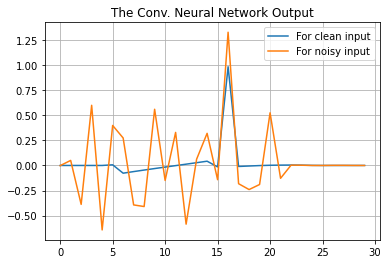

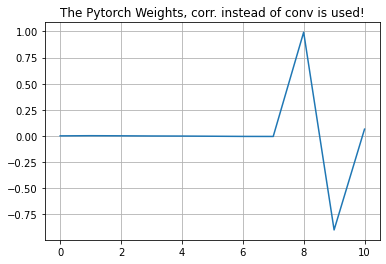

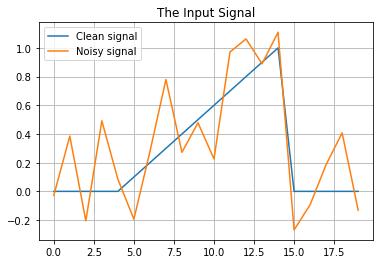

In [49]:
print("Y=", Y)
plt.figure()
plt.plot()
plt.plot(Ydet[0,0,:])
plt.plot(Ydetnoisy[0,0,:])
plt.legend(('For clean input', 'For noisy input'))
plt.title('The Conv. Neural Network Output')
plt.grid()
plt.figure()
plt.plot(weights[0].data.numpy()[0,0,:])
plt.title('The Pytorch Weights, corr. instead of conv is used!')
plt.grid()
plt.figure()
plt.plot(x)
plt.plot(xnoisy)
plt.legend(('Clean signal', 'Noisy signal'))
plt.title('The Input Signal')
plt.grid()

The figure shows the obtained weights or coefficients, in pytorch they are used as correlation instead of convolution, and hence the plot is a **time-reversed** impulse response.

Observe that it looks indeed different from our matched filter, which was simply the (time-reversed) ramp signal. This is because the optimization also tries to minimized the output outside the detection time point.

The result of the detection for the clean and noisy signals.

Observe the peak at the detection time point is indeed much **more narrow** than for the matched filter!

### An Audio Predictor

In [28]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/ZJItTGYwmew?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

We also use the mean squared error as minimization criterion or "loss function". In this case this does not differ from the target of the closed form formulation, and hence we obtain almost the same solution. Here, the desired target signal Y is
the audio input signal X, but 1 sample in the future,

```python
X=audio[:-L] #remove last samples (conv makes it longer again)
Y=audio[1:] #remove first sample, for the signal to predict, 1 sample  in the future.
```

In [50]:
# -*- coding: utf-8 -*-
__author__ = 'Gerald Schuller'
__copyright__ = 'G.S.'

"""
Simple program to use a convolutional neural network to obtain a prective coder,
using explicit inputs to layers, to enable skip layers.
According to: https://keras.io/getting-started/functional-api-guide/
With Pytorch
For instance according to WCLMS or prediction Boosting
Gerald Schuller, November 2018.
""";
# Ported to Jupyter Notebook by Renato Profeta, October 2020

In [51]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sys
import librosa
  
if sys.version_info[0] < 3:
   # for Python 2
   import cPickle as pickle
else:
   # for Python 3
   import pickle

L=12 #filter length
dilation=1 #Dilation: upsampling the filter impulse response, new filter length: (L-1)*dilation+1

In [52]:
def format_vector2pytorch(vector):
    #Function to convert a vector, like a mono audio signal, into a 3-d Tensor X that Keras expects
    #Tensor X with shape (batch, signal):
    #https://discuss.pytorch.org/t/confused-about-tensor-dimensions-and-batches/4761
    X = np.expand_dims(vector, axis=0)  #add batch dimension (here only 1 batch)
    X = np.expand_dims(X, axis=0)
    X=torch.from_numpy(X)
    X=X.type(torch.Tensor)
    return X

In [53]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Define the model. 
        self.layer1=nn.Sequential(nn.Conv1d(in_channels=1, out_channels=1, kernel_size=L, stride=1, 
                                            dilation=dilation, padding=dilation*(L-1), bias=False))
        #https://pytorch.org/docs/stable/nn.html#conv1d  
        # Generate a convolutional neural network model, 1 layer, no bias, linear activation function 
        # returns: Trainable object
        #concatenate data:
        #https://discuss.pytorch.org/t/concatenate-layer-output-with-additional-input-data/20462
        #input of layer: x, output of layer: out
    def forward(self, x):
        out = self.layer1(x)
        return out

Generate Model:
Input X.shape= torch.Size([1, 1, 99988])
Target Y.shape= torch.Size([1, 1, 99999])


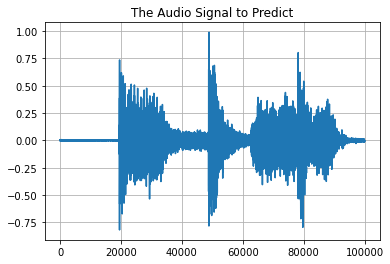

In [54]:
#Example to find prediction coefficients to minimize the mean absolute error using Python Keras
#and 1 Convolutional layer as a predictor.

import librosa
#Input mono audio signal X:
audio, samplerate = librosa.load("./audio/ACDC - Back In Black Intro.wav", sr=None, offset=6)
#samplerate, audio = wav.read("mspeech.wav")
#samplerate, audio = wav.read("fspeech.wav")
#samplerate, audio = wav.read("WCLMSprederror.wav")
#audio=audio*1.0/2**15 #normalize
audio=audio*1.0/np.max(np.abs(audio)) #normalize
    
audiosh=audio[:100000] #shorten the signal for faster optimization,
#audiosh=audio[46750:47750]
plt.figure()
plt.plot(audiosh)
plt.title("The Audio Signal to Predict")
plt.grid()

    
X=format_vector2pytorch(audiosh[:-((L-1)*dilation+1)])      #remove last samples 
Y=format_vector2pytorch(audiosh[1:]) #remove first sample, for the signal to predict, 1 sample in the future
    
print("Generate Model:")
print("Input X.shape=", X.shape )
print("Target Y.shape=", Y.shape)

import IPython.display as ipd
display(ipd.Audio(audiosh, rate=samplerate));


In [55]:
print("Generate Model:")
#model = generate_model()     # Compile an neural net
model = ConvNet()#.to('cpu')
print("Def. loss function:")
loss_fn = nn.MSELoss(reduction='sum')
#learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)

Generate Model:
Def. loss function:


In [56]:
for epoch in range(6000):
    Ypred=model(X)
    loss=loss_fn(Ypred, Y)
    if epoch%100==0:
        print(epoch, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 2249.064453125
100 452.20294189453125
200 241.7789306640625
300 218.86203002929688
400 201.8438262939453
500 186.9454345703125
600 174.44940185546875
700 164.1964111328125
800 155.8034210205078
900 148.8310546875
1000 142.88180541992188
1100 137.64329528808594
1200 132.89474487304688
1300 128.49276733398438
1400 124.35121154785156
1500 120.42094421386719
1600 116.67474365234375
1700 113.09700775146484
1800 109.67774963378906
1900 106.40939331054688
2000 103.28536224365234
2100 100.29945373535156
2200 97.44573974609375
2300 94.71839904785156
2400 92.1119155883789
2500 89.62094116210938
2600 87.24029541015625
2700 84.96499633789062
2800 82.79017639160156
2900 80.71112060546875
3000 78.72314453125
3100 76.82174682617188
3200 75.00236511230469
3300 73.26058197021484
3400 71.59196472167969
3500 69.99212646484375
3600 68.45683288574219
3700 66.98185729980469
3800 65.56307983398438
3900 64.19651794433594
4000 62.878387451171875
4100 61.604976654052734
4200 60.37281799316406
4300 59.17864227

In [57]:
torch.save({'epoch': epoch,
       'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict()}, "linpredweights.torch")

In [58]:
#Processing full length signal:
X=format_vector2pytorch(audio[:-((L-1)*dilation+1)])  #remove last samples 
Y=format_vector2pytorch(audio[1:]) #remove first sample
predictions=model(X) # Make Predictions based on the obtained weights, on short audio
#mean squared predicton error:
err= sum((predictions[0,0,:]-Y[0,0,:])**2)/max(Y.shape)
print("mean squared prediction error=", err)
#mean signal power:
sigpow=sum(X[0,0,:]**2)/max(X.shape)
print("mean signal power=", sigpow)
print("Signal to Error Power Ratio:", sigpow/err)
    
ww = model.state_dict()   #read obtained weights
print("ww=", ww)
#weight format for Conv1d:
#[0: filter weights, 1: bias for first layer]
#weight: filters of shape: out_channels× in_channelsgroups× kW
weights=ww['layer1.0.weight'][0,0,:]
    
    
print("weights= ", weights)
#print("Predictions[0,0,:]= ", predictions[0,0,:])

mean squared prediction error= tensor(0.0004, grad_fn=<DivBackward0>)
mean signal power= tensor(0.0125)
Signal to Error Power Ratio: tensor(28.7803, grad_fn=<DivBackward0>)
ww= OrderedDict([('layer1.0.weight', tensor([[[ 0.0255, -0.0177,  0.0434,  0.0169, -0.1015,  0.1601, -0.1216,
          -0.0522,  0.1816,  0.0588, -0.7880,  1.5651]]]))])
weights=  tensor([ 0.0255, -0.0177,  0.0434,  0.0169, -0.1015,  0.1601, -0.1216, -0.0522,
         0.1816,  0.0588, -0.7880,  1.5651])


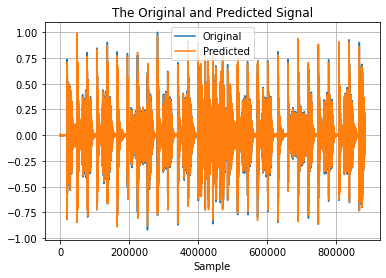

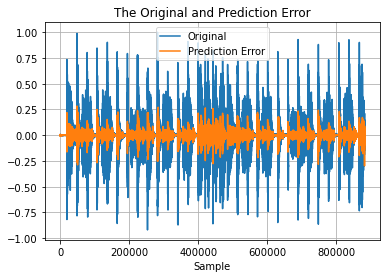

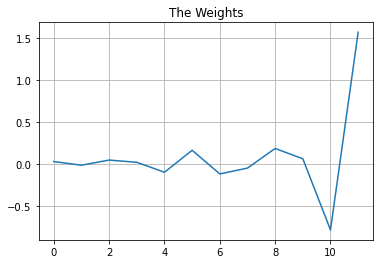

In [59]:
#print("Y=",Y)
#convert to numpy:
#https://discuss.pytorch.org/t/how-to-transform-variable-into-numpy/104/2
#plt.plot(np.array(Y[0,0,:]))
#plt.show()
plt.figure()
plt.plot(np.array(Y[0,0,:]))
plt.plot(predictions.detach().numpy()[0,0,:])
plt.legend(('Original','Predicted'))
plt.title('The Original and Predicted Signal')
plt.xlabel('Sample')
plt.grid()
plt.figure()
plt.plot(np.array(Y[0,0,:]))
plt.plot(predictions.detach().numpy()[0,0,:]-np.array(Y[0,0,:]))
plt.legend(('Original','Prediction Error'))
plt.title('The Original and Prediction Error')
plt.xlabel('Sample')
plt.grid()
plt.figure()
plt.plot(np.array(weights))
plt.title('The Weights')
plt.grid()


In [60]:
ipd.Audio(predictions.detach().numpy()[0,0,:], rate=samplerate)

### Exercise:

Design a sampling rate up-converter, for an audio signal sampled at 8 kHz to a sampling rate of 32 kHz. For the training, generate the 8 kHz version by low pass filtering and downsampling a 32 kHz version, for instance from: https://freesound.org/

Design the low pass filter as described e.g. in lecture ADSP, part 8. Also upsample it using this filter. Listen to the upsampled result. Does it have audible artifacts? If so, then there is not enough stopband attenuation (it should be at least 60 dB from passband to stopband).

Then use a convolutional neural network to interpolate the missing samples. Use the autoencoder decoder structure of the next set of slides. Train it on the audio signals, 8 kHz sample version as the input, the 32kHz original as target.

Compare the result with the traditional upsampler using the lowpass filter. Try to obtain better sounding results from the neural network.

In [27]:
%%html
<a href="https://github.com/GuitarsAI/ADSP_Tutorials">https://github.com/GuitarsAI/ADSP_Tutorials</a><br>
<iframe width="560" height="315" src="https://www.youtube.com/embed/Qd5fFXLKNq4?rel=0" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>